In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(15,6)
# Functions used in generating synthetic data

#designate randomly selected points of time that have a phase slip 
def slipper(t_array,num, debug = False):
    #num: how many phase slips should be incorporated into the frequency
    #indexInt = random.randint(0,int(len(sz)/rate))
    ti = random.choice(arange(len(t_array)),num)
    return ti

#create Phase Map
def phase_map(t_array, loc,debug = False):
    slipSz = t_array.shape
    loc = np.sort(loc)
    PhaseMap = np.ones(slipSz)*(2*np.pi*random.rand(1)-np.pi)
    for point in loc:
        PhaseMap[point:] = 2*np.pi*random.rand(1)-np.pi
    return PhaseMap

#create Amplitude Map
def amp_map(t_array, slip_loc, freq, amp_i=1, mod=0.1, mod_amp=0.05,debug = False):
    #t_array: the time series values
    #          t_array[1] is used to find the sample rate that was used
    #loc: the index of random time points that a phase shift occurrs
    #freq: frequency that is being modeled. Gaussian width is dependant on freq
    #res_width: resonance width, the bandwidth over which the power of vibration is greater than 
    #               half the power at the resonant frequency
    #gauss_width: width of gaussian curve such that frequency decays to zero at 2 periods
    #amp_i: initial amplitude of function
    #mod: frequency of amplitude madulation
    #mod_amp: amplitude of amplitude modulation
    #debug: for debugging purposes
    
    period = 1/(freq)
    gauss_width = int(2*period*(1/t_array[1]))
    
    res_width = 0.0001
    res_freq = 1
    Q_factor = res_freq/res_width
    
    dropSz = t_array.shape
    slip_loc = np.sort(slip_loc)
    
    variance = 0.1*amp_i
    t1 =time.time()
    AmpMap = np.ones(dropSz)*amp_i + random.normal(0,variance,1)
    t2 = time.time()
    if debug:
        AmpMap2 = np.copy(AmpMap)
    for point in slip_loc:
        change_up = random.normal(0,variance,1)
        if debug:
            AmpMap2[point:] = 1*amp_i + change_up
        AmpMap[point:] = (1*amp_i + change_up)*exp(-(1/Q_factor)*(t_array[point:]-t_array[point]))
        AmpMap[int(point-gauss_width/2):int(point+gauss_width/2)] = 0
    t3 = time.time()
    
    window = signal.hamming(int(gauss_width))
#     method = signal.choose_conv_method(AmpMap, window, mode='same')
    AmpMap = signal.convolve(AmpMap,window, mode='same')/sum(window)
    AmpMap  = AmpMap #+ mod_amp*sin(2*pi*mod*t_array)
    t4 = time.time()
#     print(t2-t1,t3-t2,t4-t3,t4-t1, end='\r')
    if debug:
        return AmpMap,AmpMap2
    return AmpMap

def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

def butterworth_lowpass(sig, cutoff, fs = 10000):
    sos = signal.butter(8, cutoff, 'lowpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

def geophone_response(sig, cutoff, fs = 10000, lor_width = 20):
    b,a = signal.butter(sig,cutoff, 'hp', fs = fs)
    w,h = signal.freqz(b,a)
    plt.semilogx(w, 1000*lorentzian(w,cutoff,lor_width)+ 20 * np.log10(abs(h)))
    filtered = 1000*lorentzian(w,cutoff,lor_width)+ 20 * np.log10(abs(h))

def resonant_filter(sig, w_res, res_width, fs = 10000):
    fft_sig = fft.fft(sig)
    fft_freq = fft.fftfreq(len(sig),1/fs)
    sos = signal.butter(8, 12, 'highpass', fs=fs, output='sos')
    filt_freq, filt_response = signal.sosfreqz(sos,worN=len(fft_sig),fs=fs)
    lor_response = lorentzian(fft_freq,w_res,res_width)
    res_response = 1*lor_response+(20*np.log10(absolute(filt_response)))
#     res_response = 1*lor_response + (np.zeros(shape(filt_response)))
    res_response[int(len(res_response)/2)+1:] = np.flip(res_response[1:int(len(res_response)/2)])
    fft_filt = fft_sig*exp(res_response)
    fft_filt[0] = 0+0j
    
#     plot(fft_freqs,abs(fft_sig))
#     plot(fft_freqs,res_response)
#     xlim(-110,110)
#     ylim(-100,100)
#     plot(fft_freqs,absolute(fft_filt))
    
    print(len(fft.ifft(fft_filt))/fs)
    return fft.ifft(fft_filt)

def butterworth_highpass(sig, cutoff, fs = 10000):
    sos = signal.butter(10, cutoff, 'hp', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

def view_debug(arg, amp = 1,slips = 2, freq = 10, secs = 10, fs=10000):
    
    t = linspace(0,secs,secs*fs)
    ti = slipper(t,slips)
    phase = phase_map(t, ti)
    amp,amp2 = amp_map(t, ti, freq,amp_i = amp,debug=True)

    freq1 = freq*2*np.pi
    wave = amp*sin(freq1*t + phase)
    fftData = fft.fft(wave)
    freqs = fft.fftfreq(len(fftData),1/fs)
    
    if arg == 'amp':
        plot(t,amp2)
        plot(t,amp)
        plot(t,wave)
#         xlim(t[ti[1]]-4*(2*np.pi/freq),t[ti[1]]+4*(2*np.pi/freq))
        
    if arg == 'phase':
        plot(t,phase)
    
    if arg == 'wave':
        plot(t,wave)

    if arg == 'freq':
        freqs = freqs[:int(len(freqs)/2)]
        fftData = fftData[:int(len(fftData)/2)]
        plot(freqs,absolute(fftData))
        xlim(0,freq*2)
    
def noisy(t_array, amp, fs = 10000, cutoff = 300):
    noise = amp*randn(len(t_array))
    sos = signal.butter(10, cutoff, 'low', fs = fs, output = "sos")
    filtered = signal.sosfilt(sos, noise)
    return filtered

def create_wave(freq_array, amp_array, secs = 10, fs = 10000, slips = 10):
    
#     t1 = time.time()
    t_array = linspace(0,secs,secs*fs)

    
    low_noise = noisy(t_array,0.000005)
    #     Johnson = 0.005*randn(len(t))
    tempWave = np.zeros(len(t_array)) + low_noise
#     print(time.time()-t1)
    for freq,ampi in zip(freq_array,amp_array):
        t2 = time.time()
        ampi = ampi/2000
        ti = slipper(t_array,slips)
        t3 = time.time()
        phase = phase_map(t_array,ti)
        t4 = time.time()
        amp = amp_map(t_array,ti,freq,amp_i = ampi)
        t5 = time.time()
        tempWave += amp*sin(2*np.pi*freq*t_array + phase)
        t6=time.time()
        print(t6-t2, end='\r')
        
#     fig, (ax_wave,ax_freq) = plt.subplots(2, 1)
#     ax_wave.plot(t_array,tempWave)
#     ax_wave.set_xlim([0, secs])
#     ax_wave.set_title('Synthetic Data')
#     fftData = absolute(fft.fft(tempWave)/secs)
#     freq = fft.fftfreq(len(fftData),1/fs)
#     ax_freq.loglog(freq[:int(len(freq)/2)],fftData[:int(len(fftData)/2)])
#     ax_freq.set_xlim(0,400)#max(freq_array))
# #     ax_freq.set_ylim(0,1)
#     ax_freq.set_title('Synthetic Data')
    
    return tempWave, t_array




# Subtract mean and divide by range.
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))

def lorentzian(w, w0, g):
    return (1/pi) * (g/2) / ( (w-w0)**2 + (g/2)**2 )


# figsize(15,6)
# view_debug('amp',amp= 0.5,slips = 1,freq = 2,secs = 10)

In [317]:
a = np.asarray([1,2,3,4,5,6,7,8,9])
d = np.diag(a)
print(np.flip(d,axis=1))
print(d)

[[0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 4 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 6 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 9]]


## Idealized Transfer Function

0.05
200000


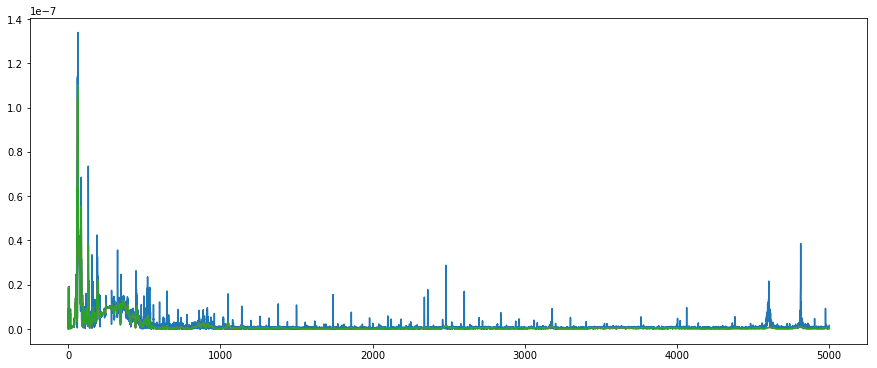

In [126]:
#load real, calibrated transfer function
[transf_Alb, freqs_Alb] = joblib.load('Albert_Data/2019-02-26/trx2_v2')

transf = transf_Alb
freqs = freqs_Alb
print(freqs[1])
#create log spaced 
w_log = logspace(log10(freqs[1]),log10(freqs[-1+int(len(freqs)/2)]),100000)

T_log = transf(w_log) #transf is already an interpolation of frequencies

window = signal.hamming(int(200))
T_flt2 = signal.convolve(T_log,window, mode='same')/sum(window)

plot(w_log,absolute(T_log))
plot(w_log,absolute(T_flt2))


f = scipy.interpolate.interp1d(w_log,T_flt2, kind='linear')

w_lin = linspace(w_log[0],w_log[-1],99999)
transf_flt = np.zeros(shape(freqs),dtype=np.complex64)

transf_flt[1:100000] = f(w_lin)
transf_flt[100000:] = np.flip(transf_flt[:100000])

interp_transf = scipy.interpolate.interp1d(freqs,transf_flt, kind='linear')
print(len(interp_transf(freqs)))
plot(freqs[:int(len(freqs)/2)],absolute(transf_flt[:int(len(freqs)/2)]))
# plot(freqs,abs(transf_flt))
# xlim(0,400)
# xlim(1250,1270)
# ylim(0,0.1e-7)
# xlim(4800,4850)

In [5]:
#Memory Issue- shape(interp_transf(freqs)) = 200000
# diagonal version results in 200,000 * 200,000 * 32 bit = 149 GB 
# transf_diag = np.diag(interp_transf(freqs))

#Options
# 1. interate 200,000 x 1 array 200,000 times
# 2. ...
# [transf, freqs] = joblib.load('Albert_Data/2019-02-26/trx2_v2')

# new_transf = interp_transf(freqs)

# decay = 0.05
# start = time.time()
# for w in arange(len(new_transf)):
#     harmonics = [w*0.5,w,w*2,w*3,w*4,w*5,w*6]
#     amps = [decay**1,decay**0,decay**1,decay**2,decay**3,decay**4,decay**5]
#     temp_w_transf = np.zeros(shape(new_transf),dtype=np.complex64)
#     for index,mag in zip(harmonics,amps):
#         try:
#             temp_w_transf[index] = mag*new_transf[index]
#         except:
#             pass
    
# end = time.time()
# print(end-start)
# time to iterate through tranfer function: ~11.5 secs


In [6]:
figsize(15,6)
#frequencies and magnitudes found upon inspection of data from 2019-02-25
freqs = [1.6, 2, 2.5, 30, 33, 34, 36, 50, 57, 60, 100, 101, 111,
         118, 125, 263, 264, 265, 266, 267, 270]
amps = [0.6, 0.3, 0.2, 0.125, 0.01, 0.05, 0.075, 0.01, 0.08, 0.04, 0.035, 0.04, 0.06,
        0.07, 0.01, 0.02, 0.03, 0.04, 0.02, 0.03, 0.02] 
electric_freq = [60,120,180,240,300,360,420,480,540,600,660,720,780,840,900]
electric_amp =  [ 0.04,0.065, 0.3,0.06,0.15, 0.05, 0.25, 0.02, 0.08, 0.05, 0.45, 0.4, 0.45, 0.3, 0.06]

wave,t = create_wave(freqs, amps,secs = 100,slips = 100)
for freq,amp in zip(electric_freq,electric_amp):
    wave = wave + (amp/2000)*sin(freq*2*np.pi*t + (2*np.pi*random.rand(1)-np.pi))

In [7]:
def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

def create_tip_data(g_dat, transfer_function, freqs, decay = 0.05):
    tf = transfer_function(freqs)
    print(len(tf))
    tip_dat = np.zeros(shape(g_dat),dtype=type(g_dat[0]))
    w_transf = np.zeros(shape(tf),dtype=type(tf[0]))
    for w in arange(int(len(tf)/2)):
        harmonics = [int(w*0.5),w,int(w*2),int(w*3),int(w*4),int(w*5),int(w*6)]
        amps = [decay**1,decay**0,decay**1,decay**2,decay**3,decay**4,decay**5]
        temp_w_transf = np.zeros(shape(tf),dtype=type(tf[0]))
        count = 0
        for index,mag in zip(harmonics,amps):
            if index < int(len(freqs)/2):
                temp_w_transf[index] = mag*tf[index]
                temp_w_transf[-index] = mag*tf[-index]
                count = count +1
                print(w, end='\r')
            else:
                pass   
#         print(temp_w_transf)
        w_transf = w_transf + temp_w_transf
    terp_tran = scipy.interpolate.interp1d(freqs,w_transf, kind='linear')
    tip_dat = create_drive(g_dat,1/10000,terp_tran,freqs)
#     tip_dat = tip_dat + temp_tip
    return tip_dat     

200000
696.4411165714264


C:\Users\jgoet\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


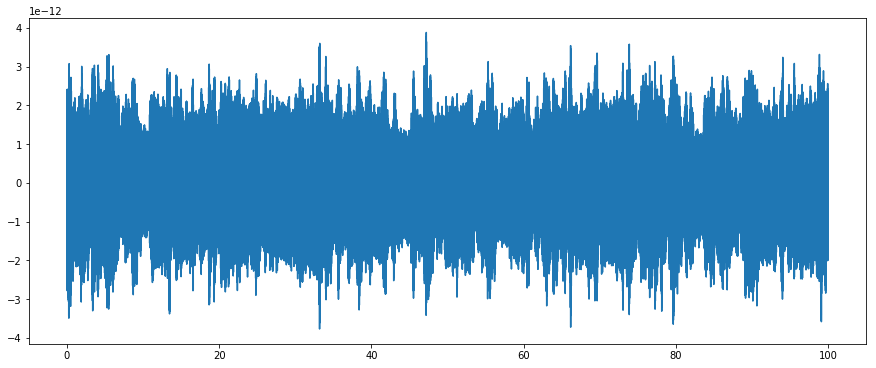

In [8]:
[transf, freqs] = joblib.load('Albert_Data/2019-02-26/trx2_v2')
start = time.time()
tip_data = create_tip_data(wave,interp_transf,freqs)
print(time.time()-start)
# # <1 sec per 100 iterations
# # 16.666 min to iterate in entirety
plot(t,tip_data)

In [306]:
def create_tip_data_3d(g_dat, transfer_function, freqs,harmonic_freqs, decay = 0.05):
    tf = transfer_function(freqs)
    lenfrq = int(len(tf)/2)
    print(len(tf))
    tip_dat = np.zeros(shape(g_dat),dtype=type(g_dat[0]))
    transf = np.zeros(len(tf),dtype=type(tf[0]))
    transf_mag = np.zeros((5,lenfrq),dtype=type(tf[0]))
    transf_index = np.zeros((5,lenfrq))
    for w in harmonic_freqs:
        w = (np.abs(freqs - w)).argmin()
        harmonics = [int(w*2),int(w*3),int(w*4),int(w*5),int(w*6)]
        amps = [decay**1,decay**2,decay**3,decay**4,decay**5]
        transf_index[:,w]= np.asarray(harmonics)
        transf_mag[:,w] = np.asarray(amps)*tf[w]
    transf_index = transf_index.astype(int)
    for index,mag in zip(transf_index.flatten(),transf_mag.flatten()):
        if index > lenfrq:
            if index < len(tf):
                index = len(tf) - index
            else:
                index,mag = 0,0
        transf[index] = transf[index] + mag
    transf[lenfrq+1:] = np.flip(transf[1:lenfrq])
    transf = transf + tf
    terp_tran = scipy.interpolate.interp1d(freqs,transf, kind='linear')
    temp_tip = create_drive(g_dat,1/10000,terp_tran,freqs)
    tip_dat = tip_dat + temp_tip
    return tip_dat,terp_tran

200000
0.7918808460235596


(0, 400)

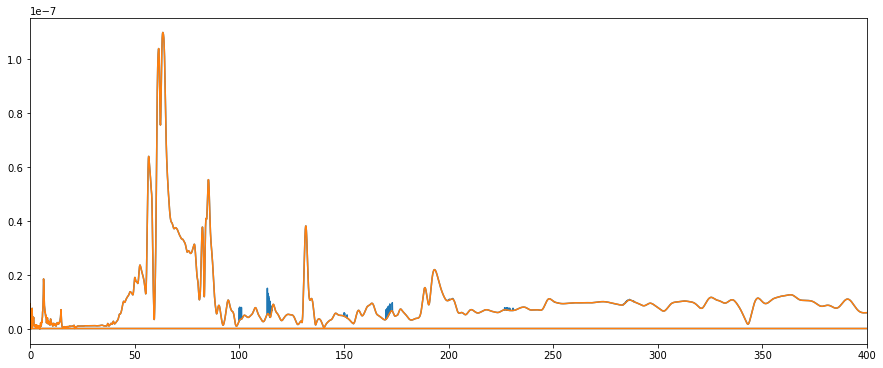

In [313]:
[transf, freqs] = joblib.load('Albert_Data/2019-02-26/trx2_v2')
# plot(freqs,absolute(transf(freqs)))
start = time.time()
harm_freqs = [56.7,56.9,57,57.1,57.3,57.7,50,50.1,50.5]
tip_data, transf_harm = create_tip_data_3d(wave,interp_transf,freqs,harm_freqs,decay=0.25)
plot(freqs,absolute(transf_harm(freqs)))
plot(freqs,absolute(interp_transf(freqs)))

print(time.time()-start)
xlim(0,400)
# # 2.9 sec to iterate in entirety
# plot(t,tip_data)

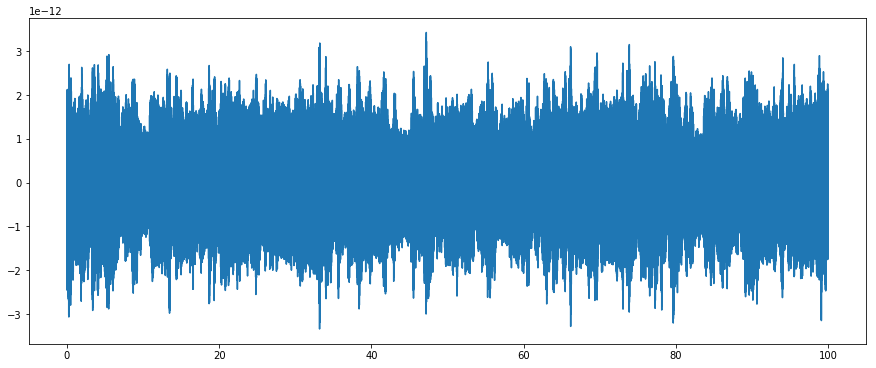

In [314]:
plot(t,tip_data)

In [312]:
w=2
decay = 0.05
harmonics = [w,int(w*2),int(w*3),int(w*4),int(w*5),int(w*6)]
amps = [decay**0,decay**1,decay**2,decay**3,decay**4,decay**5]
tfg = np.zeros((6,1))
tfg[:,0] = -np.asarray(amps)*100
print(tfg)

[[-1.000e+02]
 [-5.000e+00]
 [-2.500e-01]
 [-1.250e-02]
 [-6.250e-04]
 [-3.125e-05]]


In [249]:
A = arange(10)
ma = [1,2,3,4,5,6,7,8,9,10]
D = np.diag(A)
D_flip = np.flip(D,axis=1)
loc = np.where(A == 5)[0][0]
print(loc,shape(loc))
# print(loc[0],shape(loc[0]))
# print(loc[0][0],shape(loc[0][0]))


5 ()
